<a href="https://colab.research.google.com/github/Hsuan7/homework/blob/main/%E9%87%91%E8%9E%8D%E5%A4%A7%E6%95%B8%E6%93%9Aw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>作業要求</b>
### 1. 延用上週爬取的股價資料
### 2. 計算技術指標（SMA、RSI、MACD）
### 3. 可視化 K 線圖
### 4. 使用技術指標結合機器學習（線性回歸、決策樹、隨機森林）預測股價漲跌。技術指標作為特徵來預測第 n 天的股價

# <b>取得股價資料</b>

In [1]:
!pip install yfinance

In [2]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件

In [3]:
# 輸入股票代號
stock_id = "2330.tw"
# stock_id = "2357.tw"
# stock_id = "AAPL"
# stock_id = "NVDA"

'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
start = end - dt.timedelta(days=180)

'''抓取特定時間'''
# start = dt.datetime(2024, 1, 1)  # 指定的開始日期
# end = dt.datetime(2024, 6, 30)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
df = yf.download(stock_id, start=start, end=end).reset_index()

df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-04-08,789.0,792.0,783.0,783.0,776.522461,32202226
1,2024-04-09,795.0,820.0,792.0,819.0,812.224670,56857731
2,2024-04-10,815.0,819.0,810.0,815.0,808.257751,27480849
3,2024-04-11,811.0,820.0,811.0,820.0,813.216370,25200651
4,2024-04-12,823.0,826.0,817.0,818.0,811.232910,31508936
...,...,...,...,...,...,...,...
117,2024-09-25,1000.0,1005.0,998.0,1005.0,1005.000000,39405222
118,2024-09-26,1010.0,1015.0,1005.0,1015.0,1015.000000,38321585
119,2024-09-27,1020.0,1025.0,1000.0,1000.0,1000.000000,35783779
120,2024-09-30,978.0,990.0,957.0,957.0,957.000000,61603217


# <b>1. 技術指標的計算</b>
移動動平均線（MA）、相對強弱指數（RSI）、平滑異同移動平均線（MACD）


## 1.1 計算簡單移動平均線（SMA）

In [4]:
# 計算5日 SMA
df['5_SMA'] = df['Close'].rolling(window=5).mean()

# 計算13日 SMA
df['13_SMA'] = df['Close'].rolling(window=13).mean()

# 計算20日 SMA
df['20_SMA'] = df['Close'].rolling(window=20).mean()

# 列印最後筆數
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,5_SMA,13_SMA,20_SMA
117,2024-09-25,1000.0,1005.0,998.0,1005.0,1005.0,39405222,980.4,946.076923,941.45
118,2024-09-26,1010.0,1015.0,1005.0,1015.0,1015.0,38321585,991.4,953.538462,944.00
119,2024-09-27,1020.0,1025.0,1000.0,1000.0,1000.0,35783779,996.8,961.307692,946.85
120,2024-09-30,978.0,990.0,957.0,957.0,957.0,61603217,992.8,965.384615,947.50
121,2024-10-01,967.0,977.0,967.0,972.0,972.0,26760355,989.8,970.846154,948.70


## 1.2 計算相對強弱指數（RSI）

<img src="https://images.stockfeel.com.tw/stockfeelimage/2015/10/%E6%95%99%E4%BD%A0%E7%9C%8B%E6%87%82-RSI-%E7%9B%B8%E5%B0%8D%E5%BC%B7%E5%BC%B1%E6%8C%87%E6%A8%99-01.jpg" alt="rsi" width="500"/>

<img src="https://images.stockfeel.com.tw/stockfeelimage/2015/10/%E6%95%99%E4%BD%A0%E7%9C%8B%E6%87%82-RSI-%E7%9B%B8%E5%B0%8D%E5%BC%B7%E5%BC%B1%E6%8C%87%E6%A8%99-02.jpg" alt="rs" width="500"/>

In [5]:
# 計算每個交易日的價格變動，即當天收盤價與前一天收盤價的差異
df['Change'] = df['Close'] - df['Close'].shift(1)

# 將變動值中的正數部分視為“Gain”（增益），如果變動為負則記為0
df['Gain'] = df['Change'].apply(lambda x: x if x > 0 else 0)

# 將變動值中的負數部分視為“Loss”（損失），取其絕對值，如果變動為正則記為0
df['Loss'] = df['Change'].apply(lambda x: abs(x) if x < 0 else 0)

df.tail()

# 計算過去14個交易日的平均增益
df['Avg Gain'] = df['Gain'].rolling(window=14).mean()

# 計算過去14個交易日的平均損失
df['Avg Loss'] = df['Loss'].rolling(window=14).mean()

# 計算相對強弱指數的相對強度（RS），即平均增益與平均損失的比值
df['RS'] = df['Avg Gain'] / df['Avg Loss']

# 計算相對強弱指數（RSI），使用RS公式計算出來
df['RSI'] = 100 - (100 / (1 + df['RS']))

# 顯示最後幾行的數據
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,5_SMA,13_SMA,20_SMA,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI
117,2024-09-25,1000.0,1005.0,998.0,1005.0,1005.0,39405222,980.4,946.076923,941.45,18.0,18.0,0.0,10.285714,2.000000,5.142857,83.720930
118,2024-09-26,1010.0,1015.0,1005.0,1015.0,1015.0,38321585,991.4,953.538462,944.00,10.0,10.0,0.0,10.071429,2.000000,5.035714,83.431953
119,2024-09-27,1020.0,1025.0,1000.0,1000.0,1000.0,35783779,996.8,961.307692,946.85,-15.0,0.0,15.0,8.928571,3.071429,2.906977,74.404762
120,2024-09-30,978.0,990.0,957.0,957.0,957.0,61603217,992.8,965.384615,947.50,-43.0,0.0,43.0,8.928571,4.785714,1.865672,65.104167
121,2024-10-01,967.0,977.0,967.0,972.0,972.0,26760355,989.8,970.846154,948.70,15.0,15.0,0.0,9.642857,4.785714,2.014925,66.831683


## 1.3 計算平滑異同移動平均線（MACD）

In [6]:
'''
第一日
# 平滑係數公式： α = 2 / (span + 1) = 2 / (span + 1)
# α = 2 / (8 + 1) = 2 / (8 + 1) ≈ 0.2222
# 0.2222 * 770.0 + (1-0.2222) * 776.0 = 171.094 + 603.5728 = 774.6668
'''

# 計算8天的指數移動平均線（EMA），並將其存儲在 'EMA_8' 列中
# adjust=False 表示在計算 EMA 時，只考慮當前值和前一個 EMA 的遞歸計算方式，而不考慮所有歷史數據
df['EMA_8'] = df['Close'].ewm(span=8, adjust=False).mean()
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
# 計算13天的指數移動平均線（EMA），並將其存儲在 'EMA_13' 列中
df['EMA_13'] = df['Close'].ewm(span=13, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
# 計算MACD線：8天EMA減去13天EMA，並將其存儲在 'MACD' 列中
df['MACD'] = df['EMA_8'] - df['EMA_13']
df['MACD2'] = df['EMA_12'] - df['EMA_26']
# 顯示DataFrame的最後幾行數據
df.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume,5_SMA,13_SMA,20_SMA,...,Avg Gain,Avg Loss,RS,RSI,EMA_8,EMA_12,EMA_13,EMA_26,MACD,MACD2
117,2024-09-25,1000.0,1005.0,998.0,1005.0,1005.0,39405222,980.4,946.076923,941.45,...,10.285714,2.000000,5.142857,83.720930,970.432675,960.988206,959.338470,949.696187,11.094204,11.292020
118,2024-09-26,1010.0,1015.0,1005.0,1015.0,1015.0,38321585,991.4,953.538462,944.00,...,10.071429,2.000000,5.035714,83.431953,980.336525,969.297713,967.290117,954.533506,13.046407,14.764207
119,2024-09-27,1020.0,1025.0,1000.0,1000.0,1000.0,35783779,996.8,961.307692,946.85,...,8.928571,3.071429,2.906977,74.404762,984.706186,974.021142,971.962958,957.901394,12.743228,16.119747
120,2024-09-30,978.0,990.0,957.0,957.0,957.0,61603217,992.8,965.384615,947.50,...,8.928571,4.785714,1.865672,65.104167,978.549256,971.402504,969.825392,957.834625,8.723863,13.567880
121,2024-10-01,967.0,977.0,967.0,972.0,972.0,26760355,989.8,970.846154,948.70,...,9.642857,4.785714,2.014925,66.831683,977.093866,971.494427,970.136051,958.883912,6.957815,12.610515


# <b>2. 資料可視化</b>
K 線型態的捕捉

## 2.1 可視化收盤價折線圖

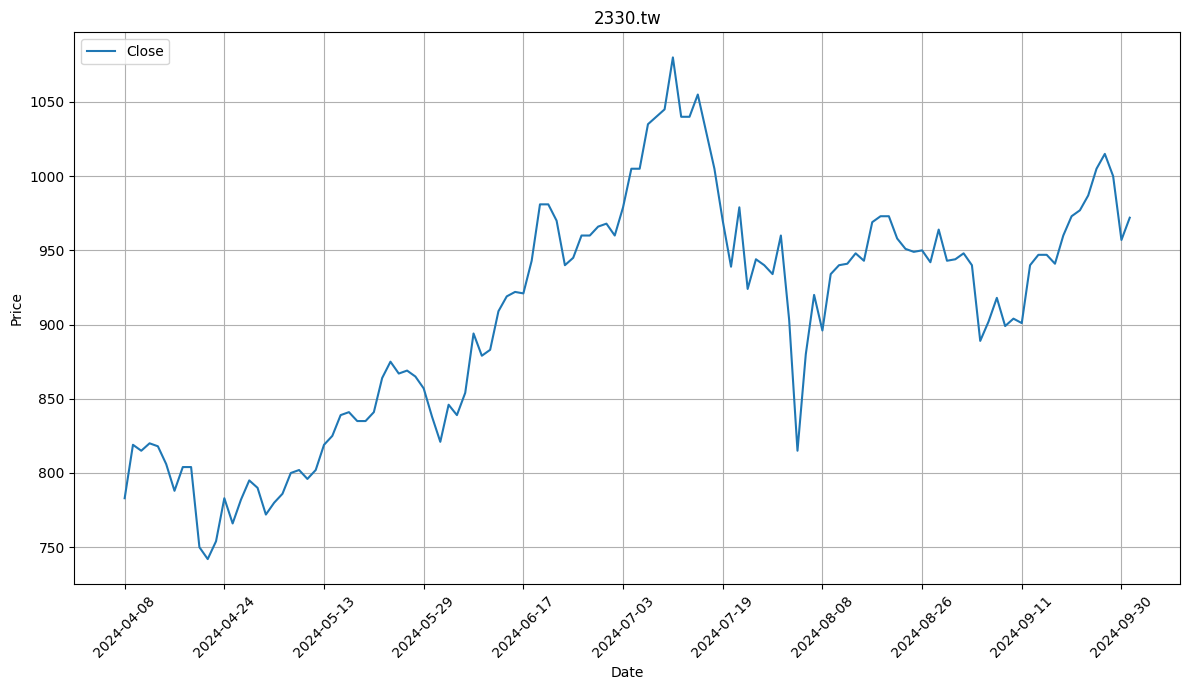

In [7]:
import matplotlib.pyplot as plt

# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))

# 設定要繪製的資料欄位
plt.plot(df['Close'], label='Close')

# 設定 x 軸的時間
num = 10
date = df["Date"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,  # 設定在 x 軸上顯示標籤的位置（索引），這些位置間隔為 len(date)//num
           date[::len(date)//num],  # 設定顯示在 x 軸上的日期標籤，數量為 num，間隔為 len(date)//num
           rotation = 45) # 讓日期標籤旋轉 45 度，以避免標籤之間重疊，提高可讀性

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title(f'{stock_id}')   # 將股票代號設為圖標
plt.xlabel('Date')         # x 軸標籤
plt.ylabel('Price')  # y 軸標籤
plt.legend(loc='upper left') # 在左上角顯示圖例
plt.grid(True) # 在圖上顯示網格
plt.tight_layout()  # 自動調整圖表中的間距，避免元素之間的重疊

# 顯示圖表
plt.show()

## 2.2 加入技術指標

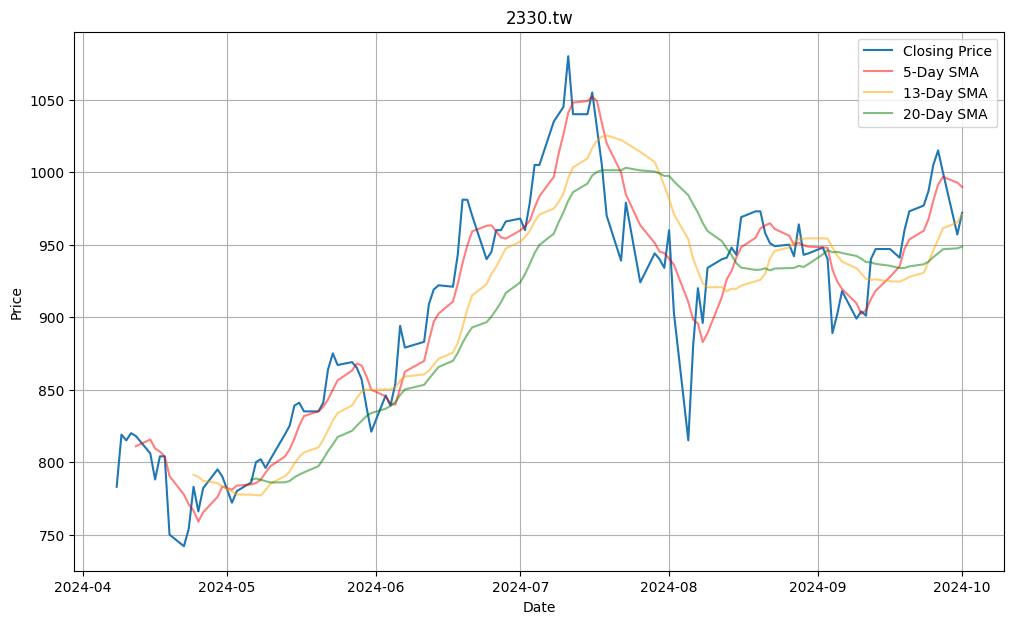

In [8]:
# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))

# 設定要繪製的資料欄位
plt.plot(df['Date'], df['Close'], label='Closing Price')

# 5 天的 SMA
plt.plot(df['Date'], df['5_SMA'], label='5-Day SMA', color='red', alpha=.5)

# 13 天的 SMA
plt.plot(df['Date'], df['13_SMA'], label='13-Day SMA', color='orange', alpha=.5)

# 20 天的 SMA
plt.plot(df['Date'], df['20_SMA'], label='20-Day SMA', color='green', alpha=.5)

# 將股票代號設為圖標
plt.title(f'{stock_id}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()

## 2.3 K 線

In [9]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.3 MB/s eta 0:00:00


In [10]:
# 將原始的 dataframe 再建立一個出來
kplot_df = df.set_index('Date')
kplot_df['2024-8-01':'2024-09-18'].tail()

,Open,High,Low,Close,Adj Close,Volume,5_SMA,13_SMA,20_SMA,Change,...,Avg Gain,Avg Loss,RS,RSI,EMA_8,EMA_12,EMA_13,EMA_26,MACD,MACD2
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-11,906.0,906.0,900.0,901.0,896.999878,18029342,904.8,926.461538,938.00,-3.0,...,4.428571,8.000000,0.553571,35.632184,912.528220,919.064126,920.382035,931.202188,-7.853815,-12.138062
2024-09-12,936.0,944.0,928.0,940.0,940.000000,39454846,912.4,925.692308,937.85,39.0,...,7.214286,7.857143,0.918182,47.867299,918.633060,922.285030,923.184601,931.853878,-4.551541,-9.568848
2024-09-13,955.0,955.0,939.0,947.0,947.000000,25347586,918.2,926.076923,936.75,7.0,...,7.642857,7.857143,0.972727,49.308756,924.936824,926.087333,926.586801,932.975813,-1.649977,-6.888480
2024-09-16,952.0,952.0,943.0,947.0,947.000000,13626239,927.8,924.769231,935.45,0.0,...,7.642857,7.285714,1.049020,51.196172,929.839752,929.304666,929.502972,934.014641,0.336780,-4.709975
2024-09-18,945.0,948.0,933.0,941.0,941.000000,28424324,935.2,924.615385,933.85,-6.0,...,6.071429,7.714286,0.787037,44.041451,932.319807,931.103948,931.145405,934.532075,1.174402,-3.428127


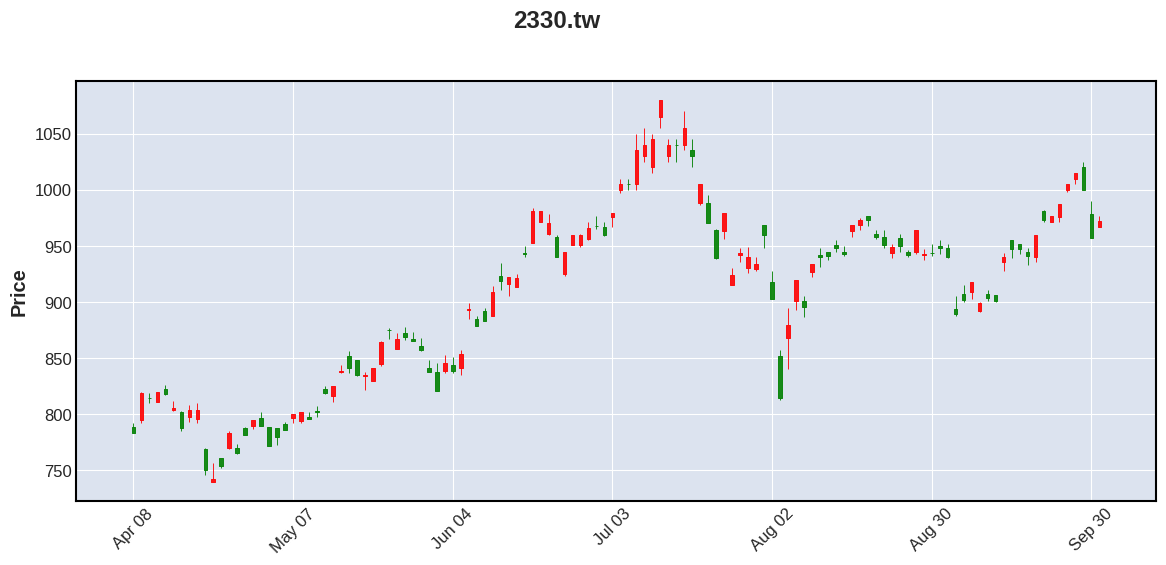

In [11]:
import mplfinance as mpf
# 設置繪圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='default',
                marketcolors=my_color)

# 使用 mplfinance 繪製 K 線圖
mpf.plot(kplot_df, type='candle', style=my_style, title=f'{stock_id}', figsize=(15, 6))

## 2.4 捕捉 Hammer 型態

錘形線（Hammer）

<img src="https://drive.google.com/uc?id=1M5t0g5kKCm2xfzRaFHfKt_CT41XSRjgb" alt="drawing" width="600"/>

In [12]:
# 計算 K 線長度 = abs(收盤-開盤)
df['body_length'] = abs(df['Close'] - df['Open'])

# 計算下影線長度 = abs(最高-最小)
df['lower_shadow'] = abs(df['Low'] - df[['Open', 'Close']].min(axis=1))

# 計算上影線長度 = abs(最高-最小)
df['upper_shadow'] = abs(df['High'] - df[['Open', 'Close']].max(axis=1))

# 定義 Hammer 型態的條件
hammer_condition = (
    (df['lower_shadow'] > 2 * df['body_length']) &  # 下影線長於實體的两倍
    (df['upper_shadow'] < df['body_length'] * 0.1) &  # 上影線很短
    (df['body_length'] < (df['High'] - df['Low']) * 0.4)  # 實體相對較小
)

# 提取 Hammer 型態
hammer_df = df[hammer_condition]
hammer_df.set_index('Date', inplace=True)

hammer_df

,Open,High,Low,Close,Adj Close,Volume,5_SMA,13_SMA,20_SMA,Change,...,RSI,EMA_8,EMA_12,EMA_13,EMA_26,MACD,MACD2,body_length,lower_shadow,upper_shadow
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-03,976.0,979.0,967.0,979.0,974.653564,24070411,966.6,959.538462,936.7,19.0,...,68.75,962.391307,954.280777,952.064255,923.623173,10.327053,30.657604,3.0,9.0,0.0


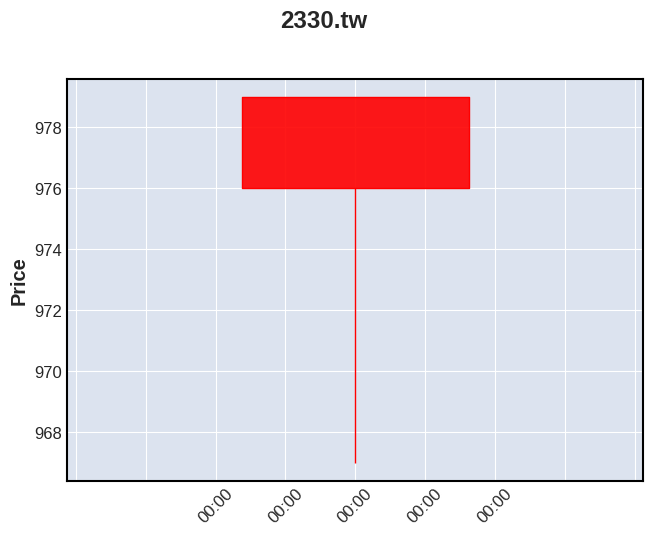

In [13]:
mpf.plot(hammer_df, type='candle', style=my_style, title=f'{stock_id}')

## 2.5 捕捉 Doji 型態

十字線（Doji）

<img src="https://drive.google.com/uc?id=1BDfcn8ZmMVgl0Xlku7mSD338WHeffrgc" alt="drawing" width="600"/>

In [14]:
# 計算 K 線長度
df['body_length'] = abs(df['Close'] - df['Open'])

# 定義Doji型態的條件
# 一般來說，body 長度 如果 小於等於 (最高價-最低價) * 0.1
doji_condition = (
    df['body_length'] <= (df['High'] - df['Low']) * 0.1  # 中間區域非常小
)

# 提取Doji形态
doji_df = df[doji_condition]
doji_df.set_index('Date', inplace=True)

doji_df

,Open,High,Low,Close,Adj Close,Volume,5_SMA,13_SMA,20_SMA,Change,...,RSI,EMA_8,EMA_12,EMA_13,EMA_26,MACD,MACD2,body_length,lower_shadow,upper_shadow
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-10,815.0,819.0,810.0,815.0,808.257751,27480849,NaN,NaN,NaN,-4.0,...,NaN,796.333333,792.609467,791.979592,787.839506,4.353741,4.769961,0.0,5.0,4.0
2024-05-20,834.0,838.0,822.0,835.0,828.092285,28808661,835.0,810.153846,797.20,0.0,...,68.181818,825.141358,817.886171,816.397990,804.637996,8.743369,13.248174,1.0,12.0,3.0
2024-05-23,875.0,877.0,867.0,875.0,867.761353,37266618,850.0,828.769231,812.25,11.0,...,89.915966,845.069254,835.221890,833.180658,816.230691,11.888595,18.991199,0.0,8.0,2.0
2024-06-06,893.0,899.0,885.0,894.0,886.604187,62925136,850.8,856.153846,846.30,40.0,...,65.945946,856.932596,852.298780,851.153759,837.139585,5.778837,15.159195,1.0,8.0,5.0
2024-06-18,944.0,950.0,940.0,943.0,938.813416,37876013,922.8,882.153846,875.30,22.0,...,68.396226,909.337345,897.118777,894.509634,869.114181,14.827711,28.004596,1.0,3.0,6.0
2024-07-01,968.0,977.0,965.0,968.0,963.702393,19935737,959.8,952.000000,924.00,2.0,...,75.147929,956.973385,947.929350,945.504124,915.928469,11.469261,32.000880,0.0,3.0,9.0
2024-07-05,1005.0,1010.0,1000.0,1005.0,1000.538147,19998094,983.4,970.769231,949.80,0.0,...,73.076923,979.224371,968.686237,966.108432,935.232487,13.115939,33.453749,0.0,5.0,5.0
2024-07-15,1040.0,1045.0,1025.0,1040.0,1035.382812,38393309,1049.0,1009.461538,992.15,0.0,...,74.869110,1032.129414,1018.364414,1015.014450,976.560903,17.114964,41.803511,0.0,15.0,5.0
2024-08-29,942.0,947.0,937.0,943.0,938.813416,43530708,949.6,954.153846,934.60,-21.0,...,53.600000,950.751921,949.774603,949.570519,949.179126,1.181402,0.595478,1.0,5.0,4.0


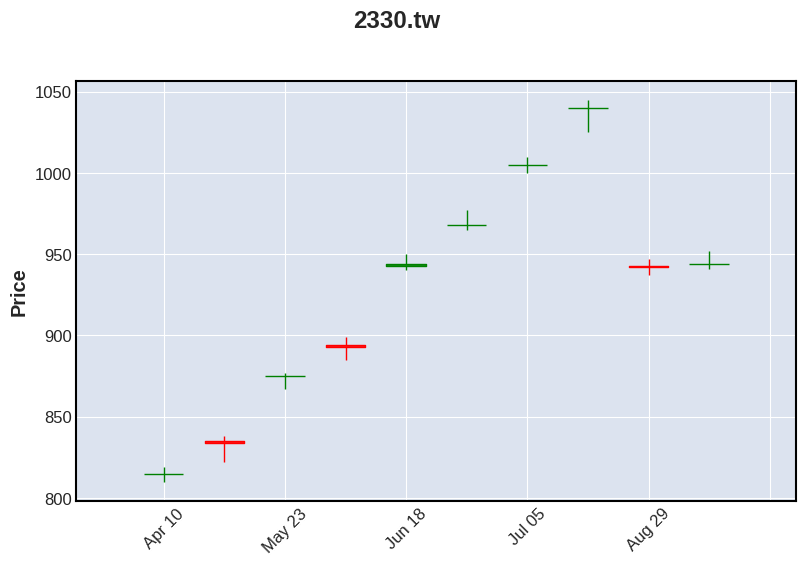

In [15]:
mpf.plot(doji_df, type='candle', style=my_style, title=f'{stock_id}', figsize=(10, 6))

# <b>3. 機器學習預測股價漲跌</b>
技術指標當特徵，用線性回歸、決策樹、隨機森林預測股價漲跌

## 3.1 資料前處理

In [16]:
import numpy as np  # 引入 numpy，用於數據處理和數值運算
from sklearn.model_selection import train_test_split  # 引入 train_test_split，用於將數據集拆分為訓練集和測試集
from sklearn.metrics import mean_squared_error  # 引入 mean_squared_error 用於評估模型性能

In [30]:
# 標籤生成: 預測未來1天的價格，這裡以2024-04-01的技術指標 預測隔天的收盤價
n = 1
df['Future_Price'] = df['Close'].shift(-n)

# 去除缺失值
df.dropna(inplace=True)

# 使用特徵
X = df[['20_SMA', 'RSI', 'MACD2']]

# 標籤（未來價格）
y = df['Future_Price']

X.shape, y.shape

((101, 3), (101,))

In [31]:
# 將數據集 X 和標籤 y 拆分為訓練集和測試集
# test_size=0.2 表示測試集佔全部數據的 20% --> 80% 的資料作為訓練，20% 的資料作為測試
# shuffle=False 表示在拆分數據時不打亂原始數據的順序
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 查看拆分後訓練集和測試集的形狀
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 3), (21, 3), (80,), (21,))

## 3.2 線性回歸（Linear Regression）

In [32]:
# 引入線性回歸模型
from sklearn.linear_model import LinearRegression

# 建立並訓練線性回歸模型
model = LinearRegression()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"線性回歸模型RMSE: {rmse:.2f}")

# 使用模型進行未來價格走勢預測
future_pred = model.predict(X[-1:])  # 使用最新的數據進行預測
print(f"線性回歸模型預測未來{n}天的價格: {future_pred[0]:.2f}")

線性回歸模型RMSE: 32.15
線性回歸模型預測未來1天的價格: 986.21


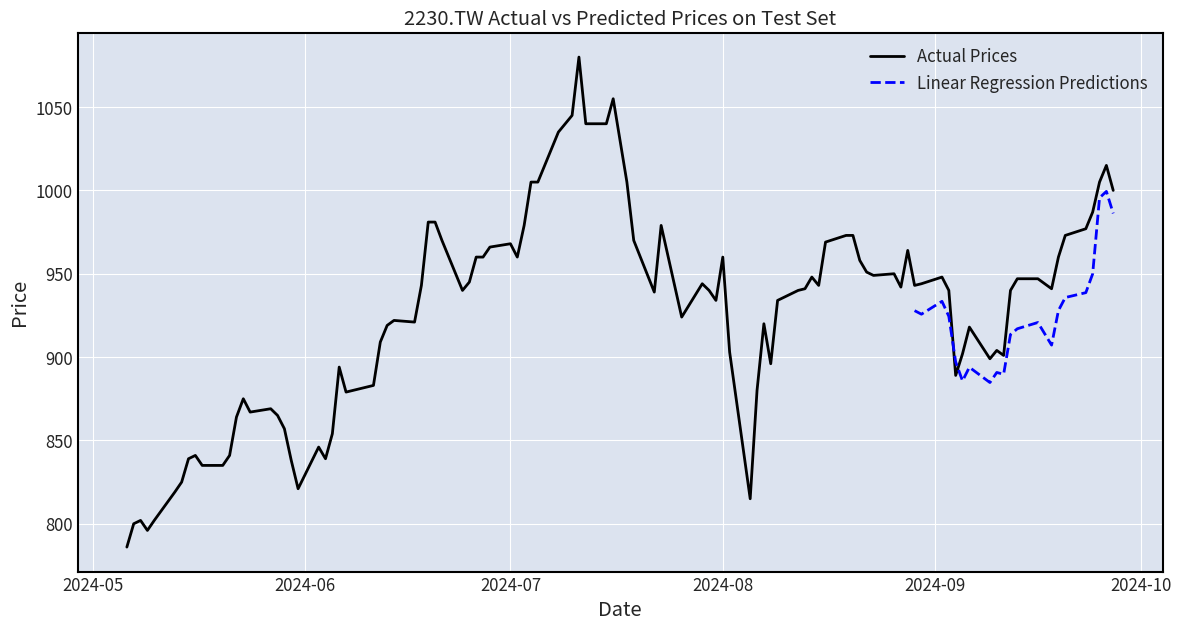

In [33]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['Date'][-len(y_test):], y_pred, label='Linear Regression Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

## 3.2 決策樹（Decision Tree）

In [34]:
from sklearn.tree import DecisionTreeRegressor

# 建立並訓練決策數模型
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"決策樹模型RMSE: {rmse:.2f}")

future_pred = model.predict(X[-1:])
print(f"決策樹模型預測未來{n}天的價格: {future_pred[0]:.2f}")

決策樹模型RMSE: 39.25
決策樹模型預測未來1天的價格: 948.00


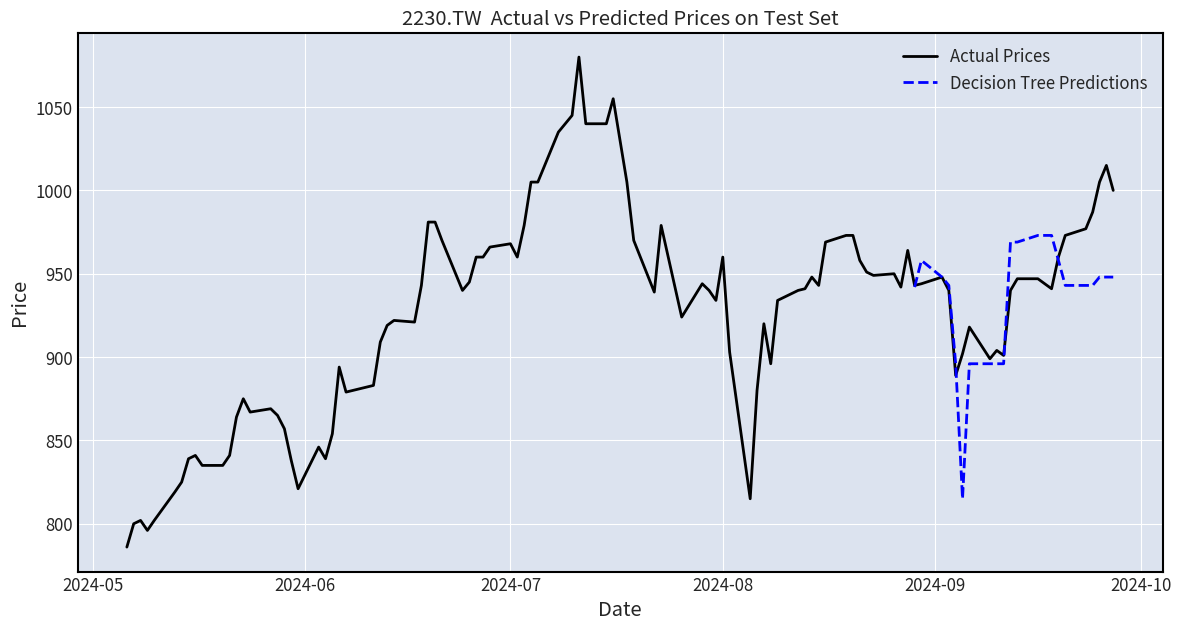

In [35]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['Date'][-len(y_test):], y_pred, label='Decision Tree Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW  Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

## 3.3 隨機森林（Random Forest）

In [36]:
# 引入隨機森林模型
from sklearn.ensemble import RandomForestRegressor

# 建立並訓練決策數模型
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"隨機森林模型RMSE: {rmse:.2f}")

future_pred = model.predict(X[-1:])
print(f"隨機森林模型預測未來{n}天的價格: {future_pred[0]:.2f}")

隨機森林模型RMSE: 35.37
隨機森林模型預測未來1天的價格: 944.00


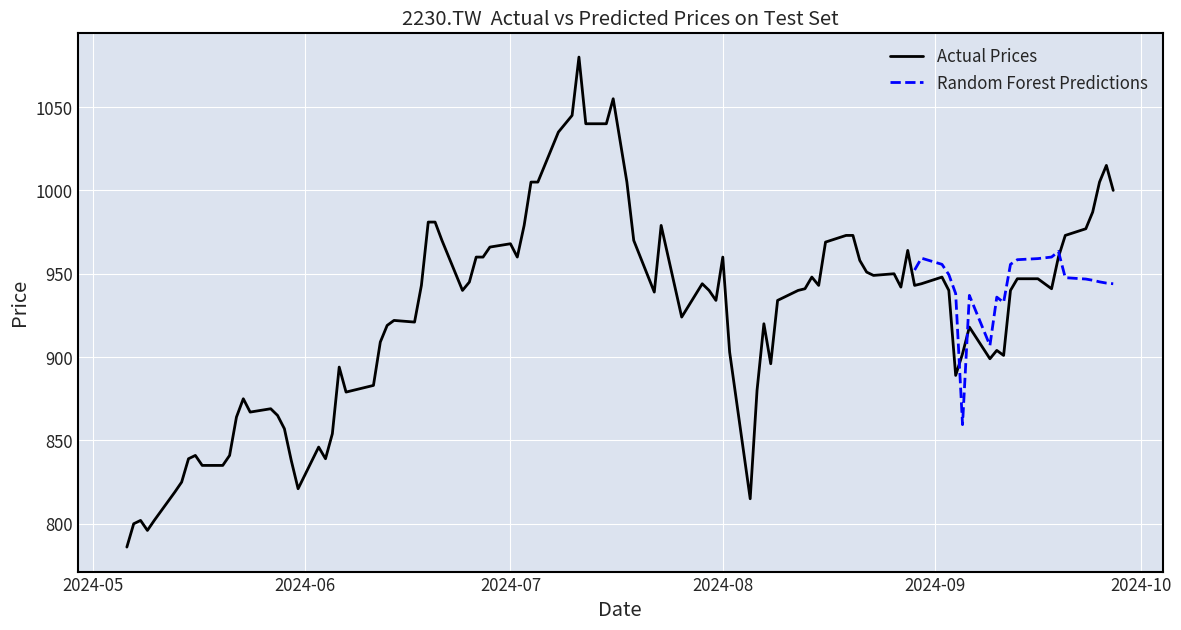

In [37]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['Date'][-len(y_test):], y_pred, label='Random Forest Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW  Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

# 補充：在 Colab 上使用中文字體

In [25]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2024-10-02 15:10:53--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.142.102, 74.125.142.138, 74.125.142.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-10-02 15:10:53--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.20.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  57.3MB/s    in 0.3s    

2024-10-02 15:10:59

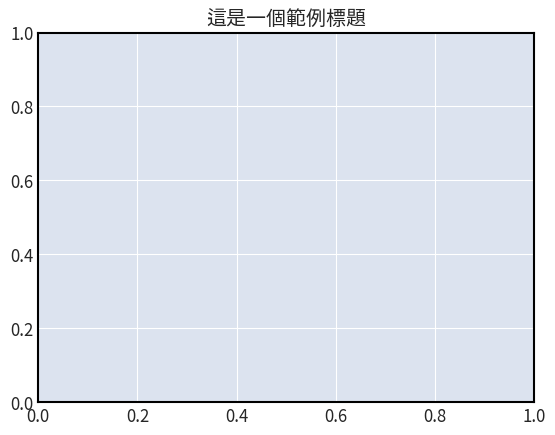

In [26]:
# 繪製範例圖表
plt.title("這是一個範例標題")
plt.show()

# Pandas Shift

In [27]:
temp_df = pd.DataFrame({
    'Date': ['2024-02-01', '2024-02-02', '2024-02-03', '2024-02-04', '2024-02-05', '2024-02-06'],
    'Close': [111, 222, 333, 444, 555, 666]
})
temp_df

,Date,Close
0,2024-02-01,111
1,2024-02-02,222
2,2024-02-03,333
3,2024-02-04,444
4,2024-02-05,555
5,2024-02-06,666


In [28]:
sample_df = pd.DataFrame({
    'Date': ['2024-02-01', '2024-02-02', '2024-02-03', '2024-02-04', '2024-02-05', '2024-02-06'],
    'SMA': ['SMA_1', 'SMA_2', 'SMA_3', 'SMA_4', 'SMA_5', 'SMA_6'],
    'RSI': ['RSI_1', 'RSI_2', 'RSI_3', 'RSI_4', 'RSI_5', 'RSI_6'],
    'MACD': ['MACD_1', 'MACD_2', 'MACD_3', 'MACD_4', 'MACD_5', 'MACD_6'],
    'Close': [111, 222, 333, 444, 555, 666]
})
sample_df

,Date,SMA,RSI,MACD,Close
0,2024-02-01,SMA_1,RSI_1,MACD_1,111
1,2024-02-02,SMA_2,RSI_2,MACD_2,222
2,2024-02-03,SMA_3,RSI_3,MACD_3,333
3,2024-02-04,SMA_4,RSI_4,MACD_4,444
4,2024-02-05,SMA_5,RSI_5,MACD_5,555
5,2024-02-06,SMA_6,RSI_6,MACD_6,666


In [29]:
sample_df['Future_Close'] = sample_df['Close'].shift(-1)
sample_df

,Date,SMA,RSI,MACD,Close,Future_Close
0,2024-02-01,SMA_1,RSI_1,MACD_1,111,222.0
1,2024-02-02,SMA_2,RSI_2,MACD_2,222,333.0
2,2024-02-03,SMA_3,RSI_3,MACD_3,333,444.0
3,2024-02-04,SMA_4,RSI_4,MACD_4,444,555.0
4,2024-02-05,SMA_5,RSI_5,MACD_5,555,666.0
5,2024-02-06,SMA_6,RSI_6,MACD_6,666,NaN
